A bunch of standard imports


In [56]:
import matplotlib.pyplot as plt
from keras.datasets import mnist #import the mnist dataset
import numpy as np

The GAN class (Generator and discriminator)

In [57]:
class GAN:
    def __init__(self, numbers, epochs=100, batch_size=64, input_layer_size_g=100,
                 hidden_layer_size_g=128, hidden_layer_size_d=128, learning_rate=1e-3,
                 decay_rate=1e-4, image_size=28, display_epochs=5):
      #Initialise hyperparameters 
        self.numbers = numbers
        self.epochs = epochs
        self.batch_size = batch_size
        self.nx_g = input_layer_size_g
        self.nh_g = hidden_layer_size_g
        self.nh_d = hidden_layer_size_d
        self.lr = learning_rate
        self.dr = decay_rate
        self.image_size = image_size
        self.display_epochs = display_epochs


        #Initialize weights for the generator
        self.W0_g = np.random.randn(self.nx_g, self.nh_g) * np.sqrt(2. / self.nx_g)  
        self.b0_g = np.zeros((1, self.nh_g))  
        self.W1_g = np.random.randn(self.nh_g, self.image_size ** 2) * np.sqrt(2. / self.nh_g)  
        self.b1_g = np.zeros((1, self.image_size ** 2))  

        #Initialize the discriminator
        self.W0_d = np.random.randn(self.image_size ** 2, self.nh_d) * np.sqrt(2. / self.image_size ** 2)  
        self.b0_d = np.zeros((1, self.nh_d))  
        self.W1_d = np.random.randn(self.nh_d, 1) * np.sqrt(2. / self.nh_d) 
        self.b1_d = np.zeros((1, 1))  
    


    #A bunch of activation functions
    def grad_tanh(self, x):
        #tanh activation function
        return 1. - np.tanh(x) ** 2

    def lrelu(self, x, alpha=1e-2):
        #Leaky ReLu function (alpha = gradient of the mapping function)
        return np.maximum(x, x * alpha)

    def grad_lrelu(self, x, alpha=1e-2):
        #Derivative of the leaky ReLu function       
        dx = np.ones_like(x)
        dx[x < 0] = alpha
        return dx

    def sigmoid(self, x):
        #Compute the sigmoid of a matrix and return a numpy array
        return 1. / (1. + np.exp(-x))

    def grad_sigmoid(self, x):
        #Return the derivative of the sigmoid for a given input matrix X
        return self.sigmoid(x) * (1. - self.sigmoid(x))

    

    #Sample a bunch of images
    def sample_images(self, images, epoch, show):
        """Generate a grid with sample images from the generator
            images -> generated images (numpy array)
            epoch -> current training iteration
            show -> if True, the grid of images is displayed
        """
        images = np.reshape(images, (self.batch_size, self.image_size, self.image_size))

        fig = plt.figure(figsize=(4, 4))

        for i in range(16):
            plt.subplot(4, 4, i + 1)
            plt.imshow(images[i] * 127.5 + 127.5, cmap='gray')
            plt.axis('off')

        if show == True:
            plt.show()
        else:
            plt.close()



    #Implement forward and backward discriminator and generator
    def forward_generator(self, z):
        #Implement forward prop via the generator
        #z -> random noise
        #z1_g -> logit output 
        #a1_g -> generated image
        self.z0_g = np.dot(z, self.W0_g) + self.b0_g
        self.a0_g = self.lrelu(self.z0_g, alpha=0)
        self.z1_g = np.dot(self.a0_g, self.W1_g) + self.b1_g
        self.a1_g = np.tanh(self.z1_g)  
        return self.z1_g, self.a1_g

    def forward_discriminator(self, x):
        #Forward prop  via the discriminator
        #x -> image batch
        #z1_d -> logit output
        #a1_d -> prediction of nature of images
        self.z0_d = np.dot(x, self.W0_d) + self.b0_d
        self.a0_d = self.lrelu(self.z0_d)
        self.z1_d = np.dot(self.a0_d, self.W1_d) + self.b1_d
        self.a1_d = self.sigmoid(self.z1_d)  
        return self.z1_d, self.a1_d

    def backward_discriminator(self, x_real, z1_real, a1_real, x_fake, z1_fake, a1_fake):
        """Implement back prop via the discriminator
            x_real -> real image batch
            z1_real -> logit ouput (real images)
            a1_real -> ouput prediction (real images)
            x_fake -> fake generated images
            z1_fake -> logit output (fake images)
            a1_fake -> output prediction (fake images) """
        
        #Sigmoid(real)
        da1_real = -1. / (a1_real + 1e-8) 
        dz1_real = da1_real * self.grad_sigmoid(z1_real)  
        dW1_real = np.dot(self.a0_d.T, dz1_real)
        db1_real = np.sum(dz1_real, axis=0, keepdims=True)

        #ReLu(real)
        da0_real = np.dot(dz1_real, self.W1_d.T)
        dz0_real = da0_real * self.grad_lrelu(self.z0_d)
        dW0_real = np.dot(x_real.T, dz0_real)
        db0_real = np.sum(dz0_real, axis=0, keepdims=True)

        #Fake input gradients
        da1_fake = 1. / (1. - a1_fake + 1e-8)

        #Sigmoid(fake)
        dz1_fake = da1_fake * self.grad_sigmoid(z1_fake)
        dW1_fake = np.dot(self.a0_d.T, dz1_fake)
        db1_fake = np.sum(dz1_fake, axis=0, keepdims=True)
         
        #ReLu(fake)
        da0_fake = np.dot(dz1_fake, self.W1_d.T)
        dz0_fake = da0_fake * self.grad_lrelu(self.z0_d, alpha=0)
        dW0_fake = np.dot(x_fake.T, dz0_fake)
        db0_fake = np.sum(dz0_fake, axis=0, keepdims=True)

        #Net gradient (real + fake)
        dW1 = dW1_real + dW1_fake
        db1 = db1_real + db1_fake

        dW0 = dW0_real + dW0_fake
        db0 = db0_real + db0_fake

        #Use stochastic gradient descent to update gradients in each pass
        self.W0_d -= self.lr * dW0
        self.b0_d -= self.lr * db0

        self.W1_d -= self.lr * dW1
        self.b1_d -= self.lr * db1

    def backward_generator(self, z, x_fake, z1_fake, a1_fake):
        """Implement back prop via the discriminator
            z -> random noise
            x_fake -> generated fake images
            z1_fake -> logit output (discriminator)
            a1_fake -> output prediction (discriminator)"""
  
        #Gradient for the fake inputs
        da1_d = -1.0 / (a1_fake + 1e-8)  

        #Sigmoid gradients
        dz1_d = da1_d * self.grad_sigmoid(z1_fake)
        da0_d = np.dot(dz1_d, self.W1_d.T)

        #ReLu gradients
        dz0_d = da0_d * self.grad_lrelu(self.z0_d)
        dx_d = np.dot(dz0_d, self.W0_d.T)
        
        #tanh gradients
        dz1_g = dx_d * self.grad_tanh(self.z1_g)
        dW1_g = np.dot(self.a0_g.T, dz1_g)
        db1_g = np.sum(dz1_g, axis=0, keepdims=True)
        
        #ReLu gradients
        da0_g = np.dot(dz1_g, self.W1_g.T)
        dz0_g = da0_g * self.grad_lrelu(self.z0_g, alpha=0)
        dW0_g = np.dot(z.T, dz0_g)
        db0_g = np.sum(dz0_g, axis=0, keepdims=True)

        #Update the gradients using stochastic gradient descent
        self.W0_g -= self.lr * dW0_g
        self.b0_g -= self.lr * db0_g
        self.W1_g -= self.lr * dW1_g
        self.b1_g -= self.lr * db1_g



    #Process available data
    def process_data(self, x, y):
        """Processes the training images and labels:
            x -> training images
            y -> raw training labels
            x_train -> processed training images
            y_train -> processed training labels
            num_batches - number of batches"""
        x_train = []
        y_train = []

        #limit the data to digits from 0-9 (since GANs can take hours to train)
        for i in range(y.shape[0]):
            if y[i] in self.numbers:
                x_train.append(x[i])
                y_train.append(y[i])

        x_train = np.array(x_train)
        y_train = np.array(y_train)

        #full batches
        num_batches = x_train.shape[0] // self.batch_size
        x_train = x_train[: num_batches * self.batch_size]
        y_train = y_train[: num_batches * self.batch_size]

        # flatten images
        x_train = np.reshape(x_train, (x_train.shape[0], -1))

        # normalise data
        x_train = (x_train.astype(np.float32) - 127.5) / 127.5

        # shuffle the data for convergence
        idx = np.random.permutation(len(x_train))
        x_train, y_train = x_train[idx], y_train[idx]
        return x_train, y_train, num_batches



    #Train the GAN
    def train(self, x, y):
        """Main method to train the GAN
            x -> training data
            y -> training labels
            J_Ds -> discriminator loss for each pass
            J_Gs -> generator loss for each pass 
        """
        J_Ds = []  #discriminator loss
        J_Gs = []  #generator loss

        #process data

        x_train, _, num_batches = self.process_data(x, y)

        for epoch in range(self.epochs):
            for i in range(num_batches):
                #input batch and noise
                x_real = x_train[i * self.batch_size: (i + 1) * self.batch_size]
                z = np.random.normal(0, 1, size=[self.batch_size, self.nx_g])  

                #forward prop (generator)
                z1_g, x_fake = self.forward_generator(z)
                z1_d_real, a1_d_real = self.forward_discriminator(x_real)
                z1_d_fake, a1_d_fake = self.forward_discriminator(x_fake)

                # cross entropy loss (a slightly different implentation from Ian Goodfellow's paper)
                J_D = np.mean(-np.log(a1_d_real) - np.log(1 - a1_d_fake))
                J_Ds.append(J_D)

                J_G = np.mean(-np.log(a1_d_fake))
                J_Gs.append(J_G)

                #back prop
                self.backward_discriminator(x_real, z1_d_real, a1_d_real,
                                            x_fake, z1_d_fake, a1_d_fake)
                self.backward_generator(z, x_fake, z1_d_fake, a1_d_fake)

            if epoch % self.display_epochs == 0:
                print(
                    f"Epoch:{epoch:}|G loss:{J_G:.4f}|D loss:{J_D:.4f}|D(G(z))avg:{np.mean(a1_d_fake):.4f}|D(x)avg:{np.mean(a1_d_real):.4f}|LR:{self.lr:.6f}")
                self.sample_images(x_fake, epoch, show=True)  # display sample images
            else:
                self.sample_images(x_fake, epoch, show=False)

            # reduce learning rate after every epoch
            self.lr = self.lr * (1.0 / (1.0 + self.dr * epoch))

        return J_Ds, J_Gs


Check the dimensions of the training vectors

In [58]:
(x_train, y_train), (_, _) = mnist.load_data()

print("y_train.shape",y_train.shape)
print("x_train.shape",x_train.shape)

y_train.shape (60000,)
x_train.shape (60000, 28, 28)


Do something concrete...

Epoch:0|G loss:0.7829|D loss:1.1813|D(G(z))avg:0.4576|D(x)avg:0.5662|LR:0.001000


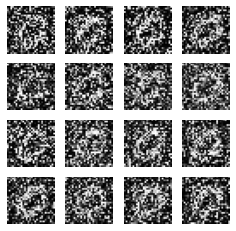

Epoch:5|G loss:0.7784|D loss:1.2096|D(G(z))avg:0.4594|D(x)avg:0.5522|LR:0.000999


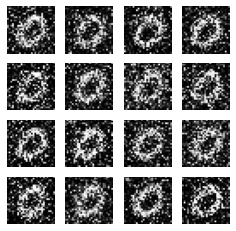

Epoch:10|G loss:0.7309|D loss:1.3140|D(G(z))avg:0.4818|D(x)avg:0.5191|LR:0.000996


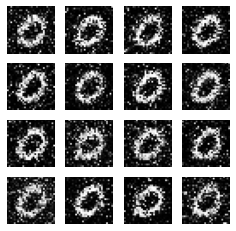

Epoch:15|G loss:0.6994|D loss:1.3763|D(G(z))avg:0.4970|D(x)avg:0.5024|LR:0.000990


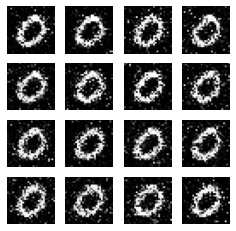

Epoch:20|G loss:0.6905|D loss:1.4023|D(G(z))avg:0.5014|D(x)avg:0.4939|LR:0.000981


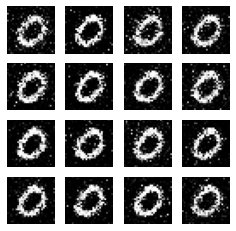

Epoch:25|G loss:0.6762|D loss:1.4258|D(G(z))avg:0.5086|D(x)avg:0.4894|LR:0.000970


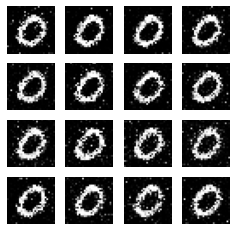

Epoch:30|G loss:0.6689|D loss:1.4392|D(G(z))avg:0.5123|D(x)avg:0.4865|LR:0.000957


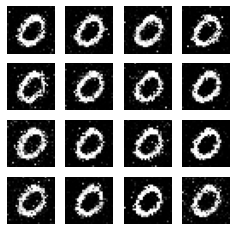

Epoch:35|G loss:0.6698|D loss:1.4429|D(G(z))avg:0.5118|D(x)avg:0.4842|LR:0.000942


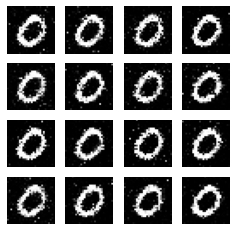

Epoch:40|G loss:0.6656|D loss:1.4493|D(G(z))avg:0.5140|D(x)avg:0.4833|LR:0.000925


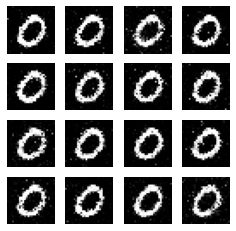

Epoch:45|G loss:0.6651|D loss:1.4501|D(G(z))avg:0.5142|D(x)avg:0.4831|LR:0.000906


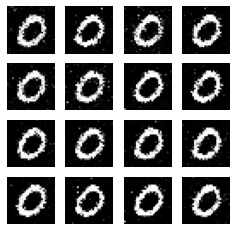

Epoch:50|G loss:0.6649|D loss:1.4494|D(G(z))avg:0.5144|D(x)avg:0.4836|LR:0.000885


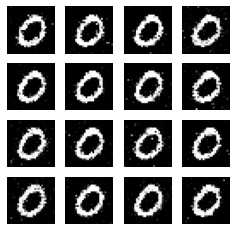

Epoch:55|G loss:0.6644|D loss:1.4475|D(G(z))avg:0.5146|D(x)avg:0.4847|LR:0.000862


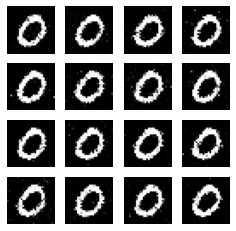

Epoch:60|G loss:0.6684|D loss:1.4404|D(G(z))avg:0.5126|D(x)avg:0.4861|LR:0.000838


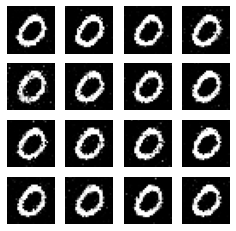

Epoch:65|G loss:0.6712|D loss:1.4333|D(G(z))avg:0.5111|D(x)avg:0.4881|LR:0.000813


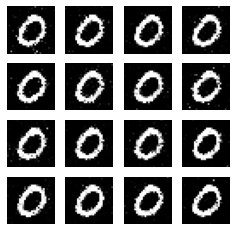

Epoch:70|G loss:0.6751|D loss:1.4249|D(G(z))avg:0.5091|D(x)avg:0.4901|LR:0.000786


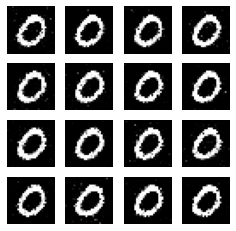

Epoch:75|G loss:0.6793|D loss:1.4163|D(G(z))avg:0.5070|D(x)avg:0.4923|LR:0.000758


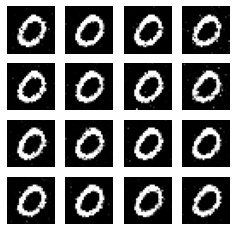

Epoch:80|G loss:0.6825|D loss:1.4078|D(G(z))avg:0.5053|D(x)avg:0.4948|LR:0.000730


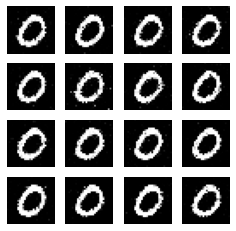

Epoch:85|G loss:0.6884|D loss:1.3964|D(G(z))avg:0.5024|D(x)avg:0.4974|LR:0.000700


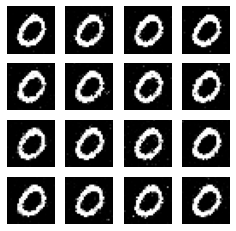

Epoch:90|G loss:0.6935|D loss:1.3856|D(G(z))avg:0.4998|D(x)avg:0.5003|LR:0.000671


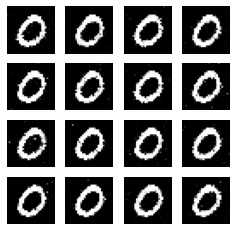

Epoch:95|G loss:0.6977|D loss:1.3751|D(G(z))avg:0.4978|D(x)avg:0.5035|LR:0.000641


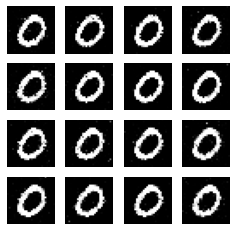

In [59]:
numbers = [0]

model = GAN(numbers, learning_rate=1e-3, decay_rate=1e-4, epochs=100)
J_Ds, J_Gs = model.train(x_train, y_train)